In [1]:
import sys
sys.path.append("models")
import model_helper as mh
import torch
import numpy as np

2.0.0


In [2]:
#We load the datasets that we will use to train, validate, and test the models. 
#We split the datasets accordingly with 50% of nodes in training set, 20% in validation set, and 30% in testing set.

ds1 = mh.Dataset()
ds1.load_dataset(folder='datasets/8K_5',splits=[.5,.2,.3],split_seed=111)

ds2 = mh.Dataset()
ds2.load_dataset(folder='datasets/32K_5',splits=[.5,.2,.3],split_seed=222)

device: cpu
loading dataset datasets/8K_5 | length: 8032 | fraud percentage (%): 4.38
device: cpu
loading dataset datasets/32K_5 | length: 32013 | fraud percentage (%): 4.67


In [3]:
#we can view our feature matrix X
print(ds1.data.X)
#and our target vector y
print(ds1.data.y)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0070,  0.0004, -0.0004],
        [ 0.0122,  0.0000,  0.0000,  ...,  0.0253,  0.0258, -0.0225],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0107,  0.0079,  0.0012],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0100,  0.0005, -0.0005],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0078,  0.0002, -0.0002],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0136,  0.0076, -0.0076]])
tensor([0, 0, 0,  ..., 0, 0, 0])


In [5]:
#now we can load our model and specify some hyperparameters

#Lets first load in the GIN model
model = mh.Model(ds1.data,gridsearch_flag=True) #init model
model.beta = .44 #set binary cross entropy weight of majority class
model.lr = 0.005 #set the learning rate
model.load_model("GIN",K=2,F=8) #load the model type with specified number of layers K and hidden-dimension F
model.train_model(epochs=1000) #train the model! (for better performance, 5000 epochs is sufficient)

device: cpu
model training starting...


/Users/julienschmidt/anaconda3/envs/GDL/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/julienschmidt/anaconda3/envs/GDL/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/julienschmidt/anaconda3/envs/GDL/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

model training done. elapsed time: 48.73 seconds


In [11]:
#lets view some results

#here we find the results of the best trained model for all epochs
print("Results of model after all epochs")
print(model.run_results)
print()

print("Results on test dataset after training")
print(model.test_model(ds1.data)) #this is simply the model at the last epoch of training.. maybe not the best performing epoch



Results of model after all epochs
{'test_f1': 0.7699530516431924, 'test_auc': 0.8589137042930178, 'test_precision': 0.82, 'test_recall': 0.7256637168141593, 'test_epoch': 390}

Results on test dataset after training
test acc: 98.22
test precision: 88.04
test recall: 71.68
test f1-score: 79.02
None


/Users/julienschmidt/Development/Projects/GAMLnet/models/model_helper.py:342: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accounts_df['trained_color'][data.train_mask.cpu().numpy()] = 2
/Users/julienschmidt/Development/Projects/GAMLnet/models/model_helper.py:343: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accounts_df['trained_color'][data.val_mask.cpu().numpy()] = 2
/Users/julienschmidt/Development/Projects/GAMLnet/models/model_helper.py:344: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

('Cycle', 'Fan In', 'Fan Out', 'Gather Scatter', 'Scatter Gather', 'Bipartite', 'Stack') [0.76 0.78 0.62 1.   0.94 0.59 0.31]
('Cycle', 'Fan In', 'Fan Out', 'Gather Scatter', 'Scatter Gather', 'Bipartite', 'Stack') [0.24 0.22 0.38 0.   0.06 0.41 0.69]


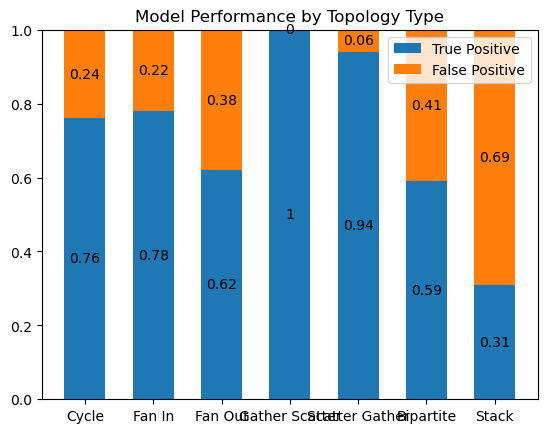

[array([0.76, 0.78, 0.62, 1.  , 0.94, 0.59, 0.31]),
 array([0.24, 0.22, 0.38, 0.  , 0.06, 0.41, 0.69])]

In [12]:
model.check_topology_performance(folder=ds1.folder, data=ds1.data)

In [9]:
#now we can load and train the GAMLNet model

#Lets specify some GAMLNet parameters
#First we define the structural features to include as node features. We only consider in-,out-degree of nodes in the simple graph format
gin_feature_indices = [ds1.feature_labels.index(item) for item in ['node_deg_out_unique', 'node_deg_in_unique']]
#Next we definet the number of layers K1 (GIN pass) and K2 (SAGE pass), and hidden layer dimensions F1 (GIN pass) and F2 (SAGE pass).
additional_params = {'K1':2, 'K2':8, 'F1':4, 'F2':16, 'gin_feature_indices':gin_feature_indices}

#Lets first load in the GIN model
model = mh.Model(ds1.data,gridsearch_flag=True) #init model
model.beta = .44 #set binary cross entropy weight of majority class
model.lr = 0.005 #set the learning rate
model.load_model("GAMLNET",additional_params=additional_params) #load the model type with specified number of layers K and hidden-dimension F
model.train_model(epochs=1000) #train the model! (for better performance, 5000 epochs is sufficient)

device: cpu
{'K1': 2, 'K2': 8, 'F1': 4, 'F2': 16, 'gin_feature_indices': [19, 11]}
model training starting...


/Users/julienschmidt/anaconda3/envs/GDL/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/julienschmidt/anaconda3/envs/GDL/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/julienschmidt/anaconda3/envs/GDL/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

model training done. elapsed time: 279.8 seconds


In [13]:
#lets view some results

#here we find the results of the best trained model for all epochs
print("Results of model after all epochs")
print(model.run_results)
print()

print("Results on test dataset after training")
print(model.test_model(ds1.data)) #this is simply the model at the last epoch of training.. maybe not the best performing epoch



Results of model after all epochs
{'test_f1': 0.7699530516431924, 'test_auc': 0.8589137042930178, 'test_precision': 0.82, 'test_recall': 0.7256637168141593, 'test_epoch': 390}

Results on test dataset after training
test acc: 98.22
test precision: 88.04
test recall: 71.68
test f1-score: 79.02
None


/Users/julienschmidt/Development/Projects/GAMLnet/models/model_helper.py:342: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accounts_df['trained_color'][data.train_mask.cpu().numpy()] = 2
/Users/julienschmidt/Development/Projects/GAMLnet/models/model_helper.py:343: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accounts_df['trained_color'][data.val_mask.cpu().numpy()] = 2
/Users/julienschmidt/Development/Projects/GAMLnet/models/model_helper.py:344: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

('Cycle', 'Fan In', 'Fan Out', 'Gather Scatter', 'Scatter Gather', 'Bipartite', 'Stack') [0.76 0.78 0.62 1.   0.94 0.59 0.31]
('Cycle', 'Fan In', 'Fan Out', 'Gather Scatter', 'Scatter Gather', 'Bipartite', 'Stack') [0.24 0.22 0.38 0.   0.06 0.41 0.69]


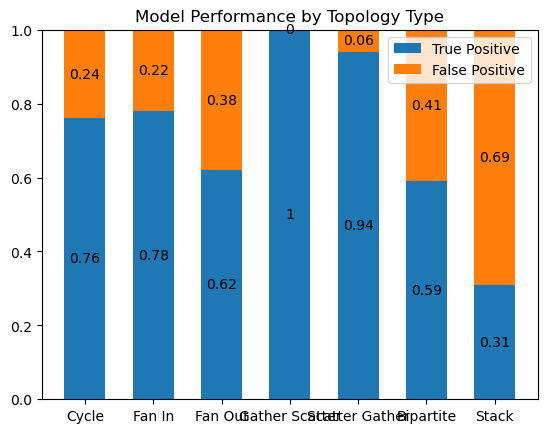

[array([0.76, 0.78, 0.62, 1.  , 0.94, 0.59, 0.31]),
 array([0.24, 0.22, 0.38, 0.  , 0.06, 0.41, 0.69])]

In [14]:
model.check_topology_performance(folder=ds1.folder, data=ds1.data)